# Continuous Control with Deep Reinforcement Learning


## OpenAI Bipedal Walker 

  This is simple 4-joints walker robot environment.
 
  There are two versions:
 
  - **Normal**, with slightly uneven terrain.
 
  - **Hardcore** with ladders, stumps, pitfalls.
  


<table><tr>
<td> <img src="images/normal_env.png"  style="width: 550px;"/> </td>
<td> <img src="images/hardcore_env.png"  style="width: 550px;"/> </td>
</tr></table>
  
  
  
We are using the Normal environment to prototype the Deep Deterministic Policy Gradient (DDPG).


#### Source

  The BipedalEnvironment was created by Oleg Klimov and is licensed on the same terms as the rest of OpenAI Gym.  
  Raw environment code: https://github.com/openai/gym/blob/master/gym/envs/box2d/bipedal_walker.py  


### Rewards Given to the Agent

  - Moving forward, total 300+ points up to the far end. 
  - If the robot falls, it gets -100. 
  - Applying motor torque costs a small amount of points, more optimal agent will get better score.

### State Space: 24 Dimensions

  - **4 hull measurements**: angle speed, angular velocity, horizontal speed, vertical speed
  - **8 joint measurements**, 2 for each of the 4 joints: position of joints and joints angular speed 
  - **2 leg measurements**, one for each leg: legs contact with ground
  - **10 lidar rangefinder measurements** to help to navigate the hardcore environment. 
  
### What quantifies a solution, or a sucessful RL agent?
  
  To solve the game you need to get **300 points in 1600 time steps**.
 
  To solve the hardcore version you need **300 points in 2000 time steps**.



In [54]:
from agents import *
import tensorflow as tf
import os
import gym
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'Agent' from 'agents' (C:\Users\Stephen\Desktop\Work\COGS 182\Project2\agents.py)

## Architecture
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FDeep-Deterministic-Policy-Gradient-DDPG-algorithm-structure_fig3_338552761&psig=AOvVaw2-8GJu9oPAVBTyJGsAmmXW&ust=1615873096160000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCICv4cfKse8CFQAAAAAdAAAAABAD

### REINFORCE
http://www.cs.toronto.edu/~guerzhoy/411/proj4/bipedal-reinforce.py

Instead of output a deterministic policy, a single value for each feature of our action vector, we will output a stochastic deterministic policy, that is, a probability distribution for each feature of our action vector.

## Critic Loss Function

Update the critic network by minimizing the loss:

$L = \frac{1}{N}\sum(y_i - Q(s_i, a_i | \theta^Q))^2$

where the target $y_i$ is equal to:
$y_i = r_i + \gamma Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$

This target is reminiscent of the update target in Q-learning, except we are substituting the known Q' values with output values from our Target Critic Network.

### Intuition
Any time we see the term $\mu(s|\theta^{\mu'})$, we should recognize that its similar to an action, $a$, except it is the output action of feeding a state $s$ into the Target Actor Network, given the target network's current weights $\theta^{\mu'}$.

To compute the Q value $Q'(s_{i+1}, \mu'(s_{i+1}|\theta^{\mu'})|\theta^{Q'})$ for this $\mu'(s_{i+1}|\theta^{\mu'})$, we feed $s'$ and $\mu'(s_{i+1}|\theta^{\mu'})$ into the Target Critic Network, since critics are responsible for generating values for a given state and action. Thus, we get $Q'(s'_{i+1},\mu'(s_{i+1}))$, and update the model using the MSE between this and the Critic Network's Q output for state $s$ and action $a$.


## Weight Updates

DDPG uses conservative policy iteration (soft updates) on the actor and critic network weights. Another term for this is Polyak Averaging.  

For example, if $\theta^Q$ is the critic network weights then:  

$\theta^{Q'} = \rho\theta^Q + (1-\rho)\theta^{Q'}$
where $\rho$ << 1


## Exploration Strategy
Add noise to the action, since the action space is continuous:

$\mu'(s) = \mu_\theta(s) + \mathcal{N}$

By adding noise, we can separate the exploration strategy from our policy. The noise employed here is generated based upon an Ornstein-Uhlenbeck process which allows for temporally correlated exploration for physical control problems involving inertia.

# Pendulum Environment: Proof-of-Concept

In [62]:
env_name = 'Pendulum-v0'

env = gym.make(env_name)
agent = Agent(env=env, env_name = env_name, layer_dims = (400,300), batch_size = 64, 
              rho = 0.01, gamma = 0.95, lr_critic= 0.005, lr_actor= 0.003, b_normalize = False)
score_history = train(agent, env, episodes = 100, debug = False, 
                           save = True)

Ep:  0 Score -1220.3 Avg -1220.3 Actions: 200
Ep:  10 Score -1492.8 Avg -1142.4 Actions: 200
Ep:  20 Score -127.2 Avg -799.9 Actions: 200
Ep:  30 Score -688.2 Avg -622.8 Actions: 200
Ep:  40 Score -134.9 Avg -535.5 Actions: 200
Ep:  50 Score -127.3 Avg -460.1 Actions: 200
Ep:  60 Score -267.2 Avg -416.6 Actions: 200
Ep:  70 Score -135.1 Avg -391.1 Actions: 200
Ep:  80 Score -124.2 Avg -297.7 Actions: 200
Ep:  90 Score -131.1 Avg -221.3 Actions: 200


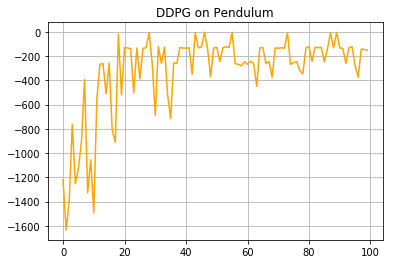

In [63]:
plt.title("DDPG on Pendulum")
plt.plot(score_history, c = 'orange', label = 'DDPG')
plt.grid()

In [66]:
## Render 5 episodes to view policy!
evaluate=True
_ =train(agent,env,episodes=5, debug=False, save=False, evaluate=evaluate)

KeyboardInterrupt: 

## Bipedal Environment

In [58]:
def train_walker(agent, env, episodes = 200, epsilon = 0, debug = True, save = True, 
          load_checkpoint = False, evaluate = False):
    
    
    score_history = []
    raw_reward_history = []
    best_score = env.reward_range[0]
    
    if load_checkpoint:
        n_steps = 0
        while n_steps <= agent.batch_size:
            observation = env.reset()
            action = env.action_space.sample()
            observation_, reward, done, info = env.step(action)
            agent.remember_experience(observation, action, reward, observation_, done)
            n_steps += 1
        agent.learn()
        agent.load_weights()
      


    ## Game Loop
 
    for i in range(episodes):
        state = env.reset()[:14]
        terminal = False
        score = 0
        raw_reward =0 
        action_sequence = []

        while not terminal:
            
            if evaluate:
                env.render()
                
            action = agent.compute_action(state, epsilon, evaluate = evaluate)
            action_sequence.append(action)
            
            state_p, reward, terminal, info = env.step(action)
            state_p = state_p[:14]
            
            raw_reward += reward
            
            # Modifications to avert agent from learning to sit still
            if (state_p[3] - state[3]) < 0.001:
                reward += -10
            score += reward
            


            agent.remember_experience(state, action, reward, state_p, terminal)

            if not evaluate:
                agent.learn()
            #else:
                #print(reward)

            state = state_p


        score_history.append(score)
        raw_reward_history.append(raw_reward)
        avg_score = np.mean(raw_reward_history[-75:])

        if avg_score > best_score:
            best_score = avg_score
            if save:
                agent.save_weights(debug=debug, iteration=i)

        if debug:
            print('Ep: ', i, 'Raw Score %.1f'% raw_reward, 'Score %.1f' % score, 'Avg %.1f' % avg_score, 
                  'Actions:', len(action_sequence))
        elif i % 10 == 0:
            print('Ep: ', i, 'Raw Score %.1f'% raw_reward, 'Score %.1f' % score, 'Avg %.1f' % avg_score, 
                      'Actions:', len(action_sequence))
    if evaluate:
        env.close()
        
    return score_history, raw_score_history

In [59]:
env_name = 'BipedalWalker-v2'
env = gym.make(env_name)
agent = Agent(env=env, env_name = env_name, layer_dims = (400,300), batch_size = 128, state_size = 14,
             rho = 0.001, gamma = 0.99, lr_critic= 0.005, lr_actor= 0.003, b_normalize = False)
norm_score_history, raw_history = train_walker(agent, env, episodes = 1000, debug = False, save = True)

Ep:  0 Raw Score -100.9 Score -100.9 Avg -100.9 Actions: 118
Ep:  10 Raw Score -118.6 Score -118.6 Avg -116.6 Actions: 38
Ep:  20 Raw Score -117.4 Score -117.4 Avg -116.5 Actions: 150
Ep:  30 Raw Score -116.3 Score -116.3 Avg -115.3 Actions: 154
Ep:  40 Raw Score -112.0 Score -112.0 Avg -115.5 Actions: 84
Ep:  50 Raw Score -118.1 Score -118.1 Avg -115.9 Actions: 37
Ep:  60 Raw Score -119.0 Score -119.0 Avg -116.8 Actions: 39
Ep:  70 Raw Score -103.5 Score -103.5 Avg -116.6 Actions: 54
Ep:  80 Raw Score -125.1 Score -125.1 Avg -119.9 Actions: 48
Ep:  90 Raw Score -115.2 Score -115.2 Avg -122.2 Actions: 41
Ep:  100 Raw Score -116.0 Score -116.0 Avg -122.9 Actions: 51
Ep:  110 Raw Score -138.8 Score -138.8 Avg -123.6 Actions: 1600
Ep:  120 Raw Score -110.8 Score -110.8 Avg -122.4 Actions: 40
Ep:  130 Raw Score -108.3 Score -108.3 Avg -123.7 Actions: 57
Ep:  140 Raw Score -108.5 Score -108.5 Avg -123.2 Actions: 37
Ep:  150 Raw Score -104.6 Score -104.6 Avg -121.6 Actions: 54
Ep:  160 Raw S

KeyboardInterrupt: 

In [60]:
agent.save_weights()


........Initializing save at Episode BipedalWalker-v2_models........
Saving Actor, Critic, and Target Networks..................


In [61]:
## Render 5 episodes to view policy!

env.close()
_ =train_walker(agent,env,episodes=10, debug=False, save=False, evaluate=True)

-0.2101150313746184
-0.0891682458619253
-0.21378147116675972
-0.22588262299200135
-0.22227855301896493
-0.21840638073285656
-0.2142740627328531
-0.20989468844731884
-0.1794617091814653
-0.15636545073986052
-0.10016236853599549
-0.14932809921105938
-0.1455072875022888
-0.12777329138914506
-0.1275927439530714
-0.12735273094971855
-0.14547121675809105
-0.1324000025987625
-0.030897514541946235
-0.05370801838238916
-0.015586930632591249
-0.052006723006565184
-0.03355134677886963
-0.017270447333656132
0.00267238267263014
0.02604560899734498
0.05268331217765809
0.08252844063440723
0.11564079769452651
0.15764311798413477
0.20505186764399325
0.25656458584467323
0.3788425112565381
0.47005978075663
0.5132168516318014
0.570221233844757
0.5699545850157737
0.6254900194505861
-0.08381111698349554
-0.22312353950738906
-0.22083373022079467
0.06763955799738686
-0.004256115873653495
0.030756611108779915
0.08964780815442286
0.1732267175912857
0.1406070773601532
0.11296838867664338
0.05662327357133112
0.05

-0.14863110733032225
-0.0943568363984414
-0.1425446883042677
-0.1961213365395852
-0.13130234332879265
-0.06527680309613783
-0.11679238867759704
-0.11753530454635619
-0.12941493244965752
-0.18015451383590697
-0.11817805620034416
-0.05416534992059309
-0.0870910379489251
-0.1437888855934143
-0.0898184394041709
-0.04811818552017212
-0.10080310356616974
-0.07356416270074627
-0.09684051118294516
-0.1532054475148507
-0.09908014686902246
-0.14270268531640606
-0.19598798604806145
-0.1311124230623245
-0.06507146509488305
-0.11709985784689703
-0.08333117417494575
-0.12139105776945512
-0.14291806670030194
-0.15134687376022338
-0.16761993022759636
-0.1258038247823715
-0.09928845020135126
-0.09507673633098603
-0.08909311544895172
-0.09802899412314216
-0.1523185188770294
-0.0980341101884842
-0.0521661679148674
-0.11259798856576166
-0.10506680921713629
-0.0989225999712944
-0.14992487665017326
-0.1381849910020828
-0.13560791464646893
-0.11970916044712065
-0.09942576440175256
-0.018013121207553946
0.021

-0.15585492702325066
-0.1064626564780883
-0.16888334753115852
-0.09423680754502851
-0.24780896457036217
-0.09636741530895233
-0.17560356509685515
-0.088175342996914
-0.012353839000068485
-0.0039998606046028964
-0.12638142359256743
0.019207806368667698
-0.1265482247074433
0.019923673053581333
-0.12538924219210823
-0.034622044881183714
-0.1805126980145796
-0.034447703778743746
-0.1960223456422464
-0.0499426340262107
-0.19566181453068932
-0.049325681249301825
-0.16479749135176458
-0.08603049468994141
-0.06590866696834564
0.06826810387770454
-0.10446950944264612
-0.08081670256455976
-0.16198612403869628
-0.023524092157680594
-0.17164517593383788
-0.06074584674835205
-0.15366713853676994
-0.012543160736560817
-0.1641258438626937
-0.11713390203316887
-0.17247120193640508
-0.0979916071097068
-0.25101253044605254
-0.07496383937199792
-0.17604383977254112
-0.03233025622367859
-0.17556442471345501
-0.08617481740315637
-0.14585749459266661
-0.11695356818040092
0.022740908940631962
-0.120516296744

KeyboardInterrupt: 

In [36]:
env.close()